# Formative Assessment

### The goal

The goal of the assignment is to predict active power of a wind turbine using several input features. The data comes from a wind farm in France, [La Haute Borne Data (2013-2016)](https://opendata-renewables.engie.com/explore/dataset/la-haute-borne-data-2013-2016/table/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6ImxhLWhhdXRlLWJvcm5lLWRhdGEtMjAxMy0yMDE2Iiwib3B0aW9ucyI6e319LCJjaGFydHMiOlt7InR5cGUiOiJsaW5lIiwiZnVuYyI6IkFWRyIsInlBeGlzIjoiYmFfYXZnIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiIzY2YzJhNSJ9XSwieEF4aXMiOiJkYXRlX3RpbWUiLCJtYXhwb2ludHMiOiIiLCJ0aW1lc2NhbGUiOiJ5ZWFyIiwic29ydCI6IiJ9XX0%3D). A total of 139 features are included in the dataset, with several measures of the same feature. For instance, the active power feature is split into the following measurements: `P_min, P_max, P_avg, P_std`. 

The overall tasks are the following:

1. Use a random forest regressor to predict power output. 
2. Perform dimension reduction using PCA.
2. Perform cross validation to determine how well the model generalises. 
3. Determine the importance of the features.
4. Determine the performance of the models as well.

The notebook will guide you as to how to go about fulfilling these overall tasks by doing other smaller subtasks.

Note that the dataset is very large, with 139 columns, so using a bit of domain knowledge we identified the following features that could be using in predicting wind turbine power output. Add to the feature subset as you build the model.



### Load the data

Import the necessary libraries and load the data. Once loaded, investigate the data. There are two files: `data_description.csv` lists the variables or features of the dataset. The file `wind-data.csv` contains the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
%matplotlib inline

Load both the `data_description.csv` and `wind-data.csv` files.

In [ ]:
description = pd.read_csv('data_description.csv', sep=';')

In [ ]:
winddata = pd.read_csv('wind-data.csv', sep=',')

__Helpful hint__: Load the data into a dataframe. Use the `parse_dates=['Date_time']` argument in the `read_csv` function in order to display dates in later plots.

In [ ]:
data = pd.read_csv('wind-data.csv', sep=';', parse_dates=['Date_time'])

In [ ]:
data.head()

### Explore the data

Once you've loaded the data into a pandas dataframe, explore the data. You may start by generating summary statistics, identifying any missing values, and filling in missing values. Generate visualizations of the features as a way to start understanding the distribution of the data.

In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

In [ ]:
data = data.fillna(data.median(axis=0))

In [ ]:
data.isnull().sum()

Because we are investigating power output, the active power feature is given by the following features in  the dataset: `P_avg, P_min, P_max, P_std`. Decide on which active power feature to use (hint: perhaps the average or maximum would be a good place to start). Begin by using the function `groupby` to determine how many turbines there are in the dataset. The dataset is huge, so in order to visualize trends in power output, a simpler way would be to look at monthly trends in the data.

I have decided to use the P_avg as the active power feature to use. This is a good indication of the mean power produced. 

In [ ]:
data['Wind_turbine_name'].nunique()

There are 4 turbines in the data set

There is a wind turbine with `Wind_turbine_name` R80711. Use this column and determine the trend for the month of January.

In [ ]:
data = data.loc[data['Wind_turbine_name'] == 'R80711']

In [ ]:
data['Date_time'] = pd.to_datetime(data['Date_time'])
data.index = data['Date_time']
Jan2013 = data.loc[(data['Date_time'] > pd.to_datetime('2013-01-01')) & (data['Date_time'] < pd.to_datetime('2013-02-01'))]
Jan2014 = data.loc[(data['Date_time'] > pd.to_datetime('2014-01-01')) & (data['Date_time'] < pd.to_datetime('2014-02-01'))]
Jan2015 = data.loc[(data['Date_time'] > pd.to_datetime('2015-01-01')) & (data['Date_time'] < pd.to_datetime('2015-02-01'))]
Jan2016 = data.loc[(data['Date_time'] > pd.to_datetime('2016-01-01')) & (data['Date_time'] < pd.to_datetime('2016-02-01'))]   

In [ ]:
data.index = data['Date_time']

In [ ]:
axis = Jan2013['P_avg'].resample('1D').sum().reset_index()['P_avg'].plot(figsize=(10, 6), linewidth=2)
Jan2014['P_avg'].resample('1D').sum().reset_index()['P_avg'].plot(ax=axis)
Jan2015['P_avg'].resample('1D').sum().reset_index()['P_avg'].plot(ax=axis)
Jan2016['P_avg'].resample('1D').sum().reset_index()['P_avg'].plot(ax=axis)

plt.title("Windturbine R80711 trend for the month of January.", fontsize=15)
plt.xlabel("January")
plt.ylabel("measured P_avg")
plt.legend(['2013-Jan','2014-Jan','2015-Jan','2016-Jan'])
plt.show()

### Find missing values

A dataset with missing values will not be usable for fitting and testing a model. Fill in missing values in a way suitable for the model.

In [ ]:
data = data.dropna(axis='columns')

### Split dataset into predictor and target matrices

In [ ]:
# Values of target
y = data['P_avg'].values

# Values of attributes
dataset = data.drop(['Date_time','Wind_turbine_name','P_avg', 'P_min', 'P_max', 'P_std'], axis=1)
X = dataset.values
dataset.head()

In [ ]:
number_features = len(dataset.columns)

### Dimension Reduction with PCA

The dataset we have it quite huge. We need to select features to use for our analysis of the active power. To discover the principal features, we can principal component analysis. First split the data into predictor and target variables. PCA allows you to reduce the number of you predictors, and to decorrelate them especially for features that have a direct relationship like apparent power, reactive power and active power.

In [18]:
pca=PCA(n_components=number_features)                                    
pca.fit(X) 

PCA(copy=True, iterated_power='auto', n_components=115, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
PCA(copy=True, n_components=None, whiten=False)
pca.components_

array([[ 9.99999998e-01,  2.80022540e-07,  4.06727163e-07, ...,
         2.49304707e-06, -4.34649961e-06, -6.90060951e-06],
       [ 5.40137474e-05, -1.78649320e-03, -1.71790499e-03, ...,
         6.83017139e-02,  4.48415321e-04,  4.17135174e-04],
       [-2.62773594e-05,  3.37107294e-03,  2.67644585e-03, ...,
         2.22165697e-01,  6.85777341e-03,  6.69221243e-03],
       ...,
       [ 1.92379080e-10,  3.45564600e-04, -1.70566875e-05, ...,
         3.44522962e-05, -6.78595075e-07, -2.63746174e-06],
       [-2.89915406e-10, -5.93897098e-06, -2.44701595e-05, ...,
        -5.40615143e-06, -1.64053716e-06, -1.19253975e-06],
       [ 7.53512991e-11,  1.51827404e-04, -2.07942244e-04, ...,
         8.88312271e-06,  2.50626726e-06, -2.28660511e-06]])

### Plot the variance

In [20]:
pca.explained_variance_ratio_

array([9.99276063e-01, 6.77311501e-04, 2.70198667e-05, 1.31895710e-05,
       3.09306370e-06, 9.52097541e-07, 8.66924391e-07, 3.06573105e-07,
       2.59218366e-07, 1.80588563e-07, 1.60190260e-07, 1.31132778e-07,
       1.15250636e-07, 6.44086230e-08, 6.26349433e-08, 4.00174330e-08,
       3.28264969e-08, 2.68125917e-08, 1.89122826e-08, 1.51433796e-08,
       1.19229154e-08, 1.16031877e-08, 9.98996382e-09, 8.19300813e-09,
       7.97956468e-09, 7.35728172e-09, 6.53117095e-09, 4.86788861e-09,
       4.77437825e-09, 3.20052470e-09, 2.80548005e-09, 2.40645783e-09,
       2.10218030e-09, 1.28424653e-09, 1.11544730e-09, 7.52540043e-10,
       7.00811714e-10, 5.40042808e-10, 3.61811600e-10, 3.18532110e-10,
       2.72922780e-10, 2.24453540e-10, 1.93794941e-10, 1.83186179e-10,
       1.51735478e-10, 1.37237611e-10, 1.13587619e-10, 1.00447689e-10,
       8.83594407e-11, 6.76857742e-11, 5.75068352e-11, 4.17557193e-11,
       3.27207924e-11, 3.19441308e-11, 2.86637699e-11, 2.56737283e-11,
      

In [21]:
pca.explained_variance_

array([5.43615304e+10, 3.68463642e+07, 1.46990543e+06, 7.17524711e+05,
       1.68265490e+05, 5.17949758e+04, 4.71614786e+04, 1.66778569e+04,
       1.41017158e+04, 9.82418276e+03, 8.71449645e+03, 7.13374289e+03,
       6.26973986e+03, 3.50388791e+03, 3.40739812e+03, 2.17698491e+03,
       1.78579141e+03, 1.45862948e+03, 1.02884545e+03, 8.23813682e+02,
       6.48617488e+02, 6.31224007e+02, 5.43463156e+02, 4.45707125e+02,
       4.34095606e+02, 4.00242845e+02, 3.55301665e+02, 2.64817586e+02,
       2.59730537e+02, 1.74111467e+02, 1.52620677e+02, 1.30913504e+02,
       1.14360528e+02, 6.98641842e+01, 6.06813520e+01, 4.09388657e+01,
       3.81247973e+01, 2.93788220e+01, 1.96828815e+01, 1.73284377e+01,
       1.48472485e+01, 1.22104776e+01, 1.05426218e+01, 9.96549547e+00,
       8.25454857e+00, 7.46585139e+00, 6.17927019e+00, 5.46444600e+00,
       4.80683427e+00, 3.68216793e+00, 3.12842436e+00, 2.27154927e+00,
       1.78004099e+00, 1.73778989e+00, 1.55933526e+00, 1.39667427e+00,
      

In [22]:
variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
variance

array([ 99.9, 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 100. , 100. ])

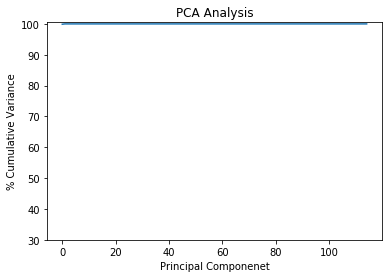

In [23]:
plt.ylabel('% Cumulative Variance')
plt.xlabel('Principal Componenet')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(variance)

### Random Forest with PCA

Construct a PCA and Random Forest Regressor pipeline. A pipeline is a term for the processing of data until it reaches a form that is usable for the machine learning algorithm. Now there is an actual pipeline module you'll need to use, that streamlines the process of dimension reduction and application of the machine learning algorithm, in this case the random forest regression model. For now, use the first two principal components to construct the pipeline.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
myPipeline = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('clf', RandomForestClassifier(random_state=42))])

In [28]:
myPipeline

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

### Plot the principal components

Select the first two components and display them. As rule of thumb, the first to components are selected as they are easier to display in a 2-dimensions.

### Split dataset in training and test sets

Split the data into training and test sets and use the pipeline to fit and test the model.

In [29]:
myPipeline.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [30]:
y_pred = pipeline.predict(X_test)

NameError: name 'pipeline' is not defined

In [31]:
y_pred

NameError: name 'y_pred' is not defined

### Evaluate the results

Using the `sklearn.metrics` moduel determine the accuracy score, i.e., the coefficient of determination $R^2$ of the prediction.

In [32]:
# Score
pipeline.score(X_test, y_test)

NameError: name 'pipeline' is not defined

### References

Referred to for determination of input features to predict power output: [Forecasting Wind Power](https://lucdemortier.github.io/articles/17/WindPower).

[Selecting good features – Part IV: stability selection, RFE and everything side by side](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)